## Task:  
Object detection (neck bones) and classification (ill / healthy / suspected).  
Model - RetinaNet.

In [0]:
%%capture
!pip install -U git+https://github.com/fizyr/keras-retinanet.git xmltodict pandas

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import xmltodict
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display
import keras
import keras_retinanet 
from keras_retinanet import models
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.utils.model import freeze
from keras_retinanet.utils.image import preprocess_image
from keras_retinanet.callbacks.common import RedirectModel
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

# Set data directory for Google Colab
from google.colab import drive
drive.mount('/content/drive')

sns.set_style("whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set default directory
DATA_DIR = "drive/My Drive/German/CareMentorAI/"
os.chdir(DATA_DIR)

DESCR_DIR = "descr/"
IMG_DIR = "images/"
MODEL_DIR = "models/"

RESNET50_WEIGHTS = "resnet50_coco_best_v2.1.0.h5"
TRAIN_CSV = "train.csv"
VAL_CSV = "validation.csv"
LABELS_CSV = "labels.csv"

In [3]:
# Load data

# Descriptions
descr_fnames = os.listdir(DESCR_DIR)

# Concat dataframes
dfs = []
for fname in (descr_fnames):
    dfs.append(pd.read_csv(DESCR_DIR + fname))

descr = pd.concat(dfs, axis=0)

# Drop empty columns
descr.dropna(axis=1, how="all", inplace=True)

print(descr.shape[0], end="\n\n")
display(descr.isnull().sum().to_frame(name="NaN count"))
display(descr.head(2))

916



,NaN count
ID,0
Исследователь,0
Кейс,0
Файлы,0
Протокол,0
XML,24
На срезе визуализируются межпозвоночные диски,20


,ID,Исследователь,Кейс,Файлы,Протокол,XML,На срезе визуализируются межпозвоночные диски
0,2872,Denis Shpak,4773 - dcm-dromanov,img_00215.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN
1,3144,Denis Shpak,4774 - dcm-dromanov,img_00226.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,Визуализируются (можно размечать)


In [4]:
# Parse coordinates and labels of bounding boxes from XML

def parse_xml(xml_string):
    """
    Extracts coordinates and names of bounding boxes from XML.
    
    Output is list of dicts with the following keys:
     - bbox: (x1, y1, x2, y2) coordinates
     - label: class label of bounding box
    """
    if not isinstance(xml_string, str):
        return np.nan
    output = []
    parsed = xmltodict.parse(xml_string)
    # List of objects
    objs = parsed["annotationgroup"]["annotation"]["object"] \
        if parsed.get("annotationgroup") is not None \
        else parsed["annotation"]["object"]    
    # Iterate over b-boxes to extract coords of its points
    for obj in objs:
        # Collect only bboxes related to neck bones
        if "shejnyj" not in obj["name"]:
            continue
        # List of coordinates for 4 points
        coords = np.array([(int(dict(p)["x"]), int(dict(p)["y"])) \
                                   for p in obj["polygon"]["pt"]])
        pt_top_left = coords.min(axis=0)
        pt_bt_right = coords.max(axis=0)
        output.append({"bbox": np.concatenate([pt_top_left, pt_bt_right]),
                       "label": obj["name"]
                      })
    return output if len(output) > 0 else np.nan

# Indices of images which might be used for training
idxs_xml = descr["На срезе визуализируются межпозвоночные диски"] == \
                                "Визуализируются (можно размечать)"
descr = descr[idxs_xml]

# Parse XML into list of dicts
descr["bboxes"] = descr["XML"].map(parse_xml)

# Strip newlines from file names
descr["Файлы"] = descr["Файлы"].str.replace("/n", "", regex=False)

# Keep only non-empty bboxes
descr.dropna(subset=["bboxes"], inplace=True)

# Drop duplicated images
descr.drop_duplicates(subset=["Файлы"], inplace=True)

print(descr.shape)
display(descr.head(3))

(343, 8)


,ID,Исследователь,Кейс,Файлы,Протокол,XML,На срезе визуализируются межпозвоночные диски,bboxes
1,3144,Denis Shpak,4774 - dcm-dromanov,img_00226.jpg,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,Визуализируются (можно размечать),"[{'bbox': [172, 107, 201, 119], 'label': 'shej..."
6,5590,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg,MRI_NECK_SAG_prot_hern,<annotationgroup><annotation>\r\n ...,Визуализируются (можно размечать),"[{'bbox': [123, 204, 164, 223], 'label': 'shej..."
9,5607,Denis Shpak,4792 - dcm-dromanov,img_00264.jpg,MRI_NECK_SAG_prot_hern,<annotationgroup><annotation>\r\n ...,Визуализируются (можно размечать),"[{'bbox': [181, 147, 208, 163], 'label': 'shej..."


→ Only 343 images are appropriate for training model

(384, 384, 3)


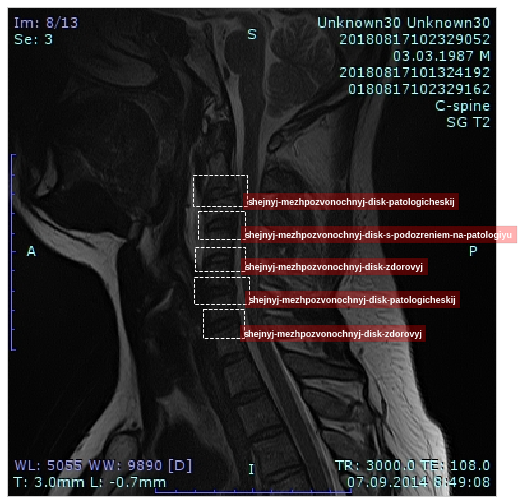

In [6]:
# Plot random image with bounding boxes
img_info = descr.sample(1)
img_fname = img_info["Файлы"].item()

# Read image
img = cv2.imread(IMG_DIR + img_fname)
print(img.shape)

# Plot image and bounding boxes
fig, ax = plt.subplots(figsize=(9,9));
ax.imshow(img);
for bb in img_info["bboxes"].item():
    ax.add_patch(patches.Rectangle(xy=bb["bbox"][:2],
                                   width=bb["bbox"][2] - bb["bbox"][0],
                                   height=bb["bbox"][3] - bb["bbox"][1],
                                   linewidth=1,
                                   linestyle="--",
                                   edgecolor="white",
                                   fill=False)
                );
    ax.text(*bb["bbox"][2:], s=bb["label"], color="white", weight="bold", 
            fontsize=9, verticalalignment="bottom", bbox=dict(facecolor="r", alpha=.3));
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

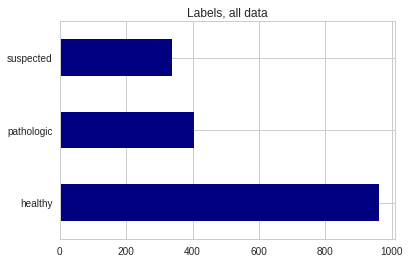

In [7]:
# Prepare data for model format

data_tuples = []
for i,r in descr.dropna(subset=["bboxes"]).iterrows():
    for bb in r["bboxes"]:                
        data_tuples.append(tuple([IMG_DIR + r["Файлы"], *bb["bbox"], bb["label"]]))

# Each row represents one bounding box
annot = pd.DataFrame.from_records(
                data_tuples, columns=["fn", "x1", "y1", "x2", "y2", "class_name"])

# Rename target labels to make them readable
labels_dict = {
                "shejnyj-mezhpozvonochnyj-disk-zdorovyj": "healthy",
                "shejnyj-mezhpozvonochnyj-disk-patologicheskij": "pathologic",
                "shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu": "suspected"
                }
annot["class_name"] = annot["class_name"].replace(labels_dict)

# Label names and ids
labels = annot[["class_name"]].drop_duplicates(subset=["class_name"])
labels["id"] = np.arange(labels.shape[0])

# Distribution of class labels
annot.class_name.value_counts().plot.barh(title="Labels, all data", color="navy");

# Split data into train / validation sets
val_fnames = IMG_DIR + descr["Файлы"].sample(frac=0.2, replace=False, random_state=13)
val = annot.loc[annot["fn"].isin(val_fnames)]
train = annot.loc[~annot["fn"].isin(val_fnames)]

# Write to CSV
val.to_csv(VAL_CSV, index=False, header=False)
train.to_csv(TRAIN_CSV, index=False, header=False)
labels.to_csv(LABELS_CSV, index=False, header=False)

In [0]:
# Clone object detection repository if needed
#!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [0]:
# Read prepared CSV files
val = pd.read_csv(VAL_CSV, names=["fn", "x1", "y1", "x2", "y2", "class_name"])
train = pd.read_csv(TRAIN_CSV, names=["fn", "x1", "y1", "x2", "y2", "class_name"])
labels = pd.read_csv(LABELS_CSV, names=["class_name", "id"])

id_2_labels = dict(zip(labels["id"], labels["class_name"]))

In [0]:
# Train / Validation generators
generator_kwargs = {
                        "image_min_side": 384,
                        "image_max_side": 384,
                        "batch_size": 1,
                        "preprocess_image": lambda x: x,
                   }

train_generator = CSVGenerator(TRAIN_CSV, LABELS_CSV, **generator_kwargs)
val_generator = CSVGenerator(VAL_CSV, LABELS_CSV, **generator_kwargs)

In [31]:
# Create and compile Retinanet model

backbone = models.backbone("resnet50")
model = backbone.retinanet(num_classes=train_generator.num_classes(), modifier=None)

# Load pretrained weights (COCO dataset)
model.load_weights(MODEL_DIR + RESNET50_WEIGHTS, by_name=True, skip_mismatch=True)

prediction_model = retinanet_bbox(model=model, anchor_params=None)

# Compile model
model.compile(loss={
                    'regression': keras_retinanet.losses.smooth_l1(),
                    'classification': keras_retinanet.losses.focal()
                    },
              optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
             );

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 27) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((27,) vs (720,)).
  weight_values[i].shape))


In [0]:
# Callbacks for evaluation and learning rate annealing

callbacks = []

evaluation = Evaluate(val_generator, tensorboard=None, weighted_average=True)
evaluation = RedirectModel(evaluation, prediction_model)
callbacks.append(evaluation)

callbacks.append(keras.callbacks.ReduceLROnPlateau(
                                            monitor='loss',
                                            factor=0.1,
                                            patience=2,
                                            verbose=1,
                                            mode='auto',
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr= 0
                                                 ))

In [33]:
# Train the model
model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.size() // train_generator.batch_size,
            epochs=15,
            verbose=1,
            callbacks=callbacks,
            workers=1,
            use_multiprocessing=True,
            max_queue_size=10
        )

Epoch 1/15
274/274 [==============================] - 100s 365ms/step - loss: 2.2933 - regression_loss: 1.4248 - classification_loss: 0.8685


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:12 Time:  0:00:12
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.2121
96 instances of class pathologic with average precision: 0.2865
67 instances of class suspected with average precision: 0.0799
mAP: 0.2071
Epoch 2/15
274/274 [==============================] - 82s 299ms/step - loss: 1.4156 - regression_loss: 0.9275 - classification_loss: 0.4881


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.3238
96 instances of class pathologic with average precision: 0.4249
67 instances of class suspected with average precision: 0.1390
mAP: 0.3160
Epoch 3/15
274/274 [==============================] - 82s 298ms/step - loss: 1.2289 - regression_loss: 0.8247 - classification_loss: 0.4042


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.4266
96 instances of class pathologic with average precision: 0.4720
67 instances of class suspected with average precision: 0.1915
mAP: 0.3936
Epoch 4/15
274/274 [==============================] - 82s 299ms/step - loss: 1.1005 - regression_loss: 0.7489 - classification_loss: 0.3516


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.5453
96 instances of class pathologic with average precision: 0.4974
67 instances of class suspected with average precision: 0.1693
mAP: 0.4589
Epoch 5/15
274/274 [==============================] - 82s 299ms/step - loss: 0.9624 - regression_loss: 0.6556 - classification_loss: 0.3067


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.5800
96 instances of class pathologic with average precision: 0.5033
67 instances of class suspected with average precision: 0.2169
mAP: 0.4881
Epoch 6/15
274/274 [==============================] - 82s 298ms/step - loss: 0.8565 - regression_loss: 0.5762 - classification_loss: 0.2802


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6414
96 instances of class pathologic with average precision: 0.5283
67 instances of class suspected with average precision: 0.1850
mAP: 0.5213
Epoch 7/15
274/274 [==============================] - 82s 299ms/step - loss: 0.7654 - regression_loss: 0.5087 - classification_loss: 0.2567


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6380
96 instances of class pathologic with average precision: 0.5392
67 instances of class suspected with average precision: 0.2161
mAP: 0.5286
Epoch 8/15
274/274 [==============================] - 82s 298ms/step - loss: 0.6756 - regression_loss: 0.4364 - classification_loss: 0.2392


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6148
96 instances of class pathologic with average precision: 0.5853
67 instances of class suspected with average precision: 0.2166
mAP: 0.5293
Epoch 9/15
274/274 [==============================] - 82s 298ms/step - loss: 0.6194 - regression_loss: 0.3973 - classification_loss: 0.2221


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6585
96 instances of class pathologic with average precision: 0.6045
67 instances of class suspected with average precision: 0.2505
mAP: 0.5642
Epoch 10/15
274/274 [==============================] - 82s 298ms/step - loss: 0.5588 - regression_loss: 0.3532 - classification_loss: 0.2056


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6476
96 instances of class pathologic with average precision: 0.6366
67 instances of class suspected with average precision: 0.2183
mAP: 0.5611
Epoch 11/15
274/274 [==============================] - 82s 298ms/step - loss: 0.5089 - regression_loss: 0.3194 - classification_loss: 0.1895


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6825
96 instances of class pathologic with average precision: 0.6337
67 instances of class suspected with average precision: 0.2922
mAP: 0.5931
Epoch 12/15
274/274 [==============================] - 82s 298ms/step - loss: 0.4704 - regression_loss: 0.2908 - classification_loss: 0.1796


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6640
96 instances of class pathologic with average precision: 0.5973
67 instances of class suspected with average precision: 0.2709
mAP: 0.5691
Epoch 13/15
274/274 [==============================] - 82s 298ms/step - loss: 0.4290 - regression_loss: 0.2665 - classification_loss: 0.1626


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6836
96 instances of class pathologic with average precision: 0.6816
67 instances of class suspected with average precision: 0.2902
mAP: 0.6066
Epoch 14/15
274/274 [==============================] - 82s 299ms/step - loss: 0.3982 - regression_loss: 0.2522 - classification_loss: 0.1460


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6911
96 instances of class pathologic with average precision: 0.6437
67 instances of class suspected with average precision: 0.2821
mAP: 0.5985
Epoch 15/15
274/274 [==============================] - 82s 299ms/step - loss: 0.3731 - regression_loss: 0.2332 - classification_loss: 0.1398


Running network: 100% (69 of 69) |#######| Elapsed Time: 0:00:05 Time:  0:00:05
Parsing annotations: 100% (69 of 69) |###| Elapsed Time: 0:00:00 Time:  0:00:00


182 instances of class healthy with average precision: 0.6937
96 instances of class pathologic with average precision: 0.6596
67 instances of class suspected with average precision: 0.2709
mAP: 0.6021


In [0]:
# Save / Load model
MODEL_FN = MODEL_DIR + "resnet50_retinanet.h5"

model.save(MODEL_FN)
model = models.load_model(MODEL_FN, backbone_name="resnet50")

# Convert to inference model
prediction_model = models.convert_model(model)

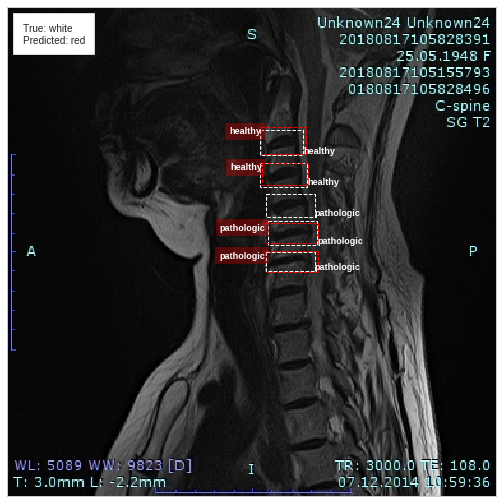

In [36]:
# Visualize random image from validation set and predictions
val_fname = val.dropna(subset=["fn"]).sample(1)["fn"].item()
val_info = val[val["fn"] == val_fname]
img = cv2.imread(val_fname)

# Plot image and true bounding boxes with labels
fig, ax = plt.subplots(figsize=(9,9));
ax.imshow(img);

for i,r in val_info.iterrows():
    ax.add_patch(patches.Rectangle(xy=tuple(r[["x1", "y1"]]),
                                   width=r["x2"] - r["x1"],
                                   height=r["y2"] - r["y1"],
                                   linewidth=1,
                                   linestyle="--",
                                   edgecolor="white",
                                   fill=False)
                );
    ax.text(*r[["x2", "y2"]], s=r["class_name"], color="white", weight="bold",
            fontsize=9, verticalalignment="bottom");

# Make predictions
bbs, scrs, lbls = prediction_model.predict_on_batch(np.expand_dims(img, axis=0))

# Draw predictions
for bb, scr, lbl in zip(bbs[0], scrs[0], lbls[0]):
    if scr < 0.5:
        break
    ax.add_patch(patches.Rectangle(xy=bb[:2],
                                   width=bb[2] - bb[0],
                                   height=bb[3] - bb[1],
                                   linewidth=1,
                                   linestyle="--",
                                   edgecolor="red",
                                   fill=False)
                );
    
    ax.text(bb[0], bb[1], s=id_2_labels[lbl], color="white", weight="bold",
            fontsize=9, verticalalignment="top", horizontalalignment="right",
            bbox=dict(facecolor="r", alpha=.3));


ax.text(12, 28, "True: white\n" + "Predicted: red",
        bbox={'facecolor': 'white', 'pad': 10});

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)